<a href="https://colab.research.google.com/github/ernselito/Effect_of_Different_Optimizers/blob/master/classification_with_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Data

In [ ]:
from datasets import load_dataset
# Load our data
data = load_dataset("rotten_tomatoes")
data

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [ ]:
data['train'][0,1]

{'text': ['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
  'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .'],
 'label': [1, 1]}

# Methodology

Classification with Representation Models

In [ ]:
from transformers import pipeline
# Path to our HF model
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
# Load model into pipeline
pipe = pipeline(model=model_path, tokenizer=model_path, return_all_scores=True)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_al

In [ ]:
import numpy as np
from tqdm import tqdm
from transformers.pipelines.pt_utils import KeyDataset
# Run inference
y_pred = []
for output in tqdm(pipe(KeyDataset(data["test"], "text")),
                   total=len(data["test"])):
                   negative_score = output[0]["score"]
                   positive_score = output[2]["score"]
                   assignment = np.argmax([negative_score, positive_score])
                   y_pred.append(assignment)

100%|██████████| 1066/1066 [02:13<00:00,  8.00it/s]


In [ ]:
from sklearn.metrics import classification_report
def evaluate_performance(y_true, y_pred):
  """Create and print the classification report"""
  performance = classification_report(y_true, y_pred,
                                      target_names=["Negative Review", "Positive Review"])
  return performance
print(evaluate_performance(data["test"]["label"], y_pred))

                 precision    recall  f1-score   support

Negative Review       0.76      0.88      0.81       533
Positive Review       0.86      0.72      0.78       533

       accuracy                           0.80      1066
      macro avg       0.81      0.80      0.80      1066
   weighted avg       0.81      0.80      0.80      1066



In [ ]:
from sentence_transformers import SentenceTransformer
# Load model
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
# Convert text to embeddings
train_embeddings = model.encode(data["train"]["text"], show_progress_bar=True)
test_embeddings = model.encode(data["test"]["text"], show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/267 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
train_embeddings.shape

In [ ]:
from sklearn.linear_model import LogisticRegression
# Train a logistic regression on our train embeddings
clf = LogisticRegression(random_state=42)
clf.fit(train_embeddings, data["train"]["label"])

# Predict previously unseen instances
y_pred = clf.predict(test_embeddings)
evaluate_performance(data["test"]["label"], y_pred)

'                 precision    recall  f1-score   support\n\nNegative Review       0.85      0.86      0.85       533\nPositive Review       0.86      0.85      0.85       533\n\n       accuracy                           0.85      1066\n      macro avg       0.85      0.85      0.85      1066\n   weighted avg       0.85      0.85      0.85      1066\n'

In [ ]:
# Performance of the second model
print(evaluate_performance(data["test"]["label"], y_pred))

                 precision    recall  f1-score   support

Negative Review       0.85      0.86      0.85       533
Positive Review       0.86      0.85      0.85       533

       accuracy                           0.85      1066
      macro avg       0.85      0.85      0.85      1066
   weighted avg       0.85      0.85      0.85      1066



In [ ]:
# Add Analysis & Improvements
misclassified_indices = [i for i, (true, pred) in enumerate(zip(data["test"]["label"], y_pred)) if true != pred]
print(f"Number of misclassified examples: {len(misclassified_indices)}")

# Look at some errors
for i in misclassified_indices[:3]:
    print(f"Text: {data['test']['text'][i]}")
    print(f"True: {data['test']['label'][i]}, Predicted: {y_pred[i]}")
    print("---")

Number of misclassified examples: 158
Text: it's like a " big chill " reunion of the baader-meinhof gang , only these guys are more harmless pranksters than political activists .
True: 1, Predicted: 0
---
Text: mostly , [goldbacher] just lets her complicated characters be unruly , confusing and , through it all , human .
True: 1, Predicted: 0
---
Text: at its worst , the movie is pretty diverting ; the pity is that it rarely achieves its best .
True: 1, Predicted: 0
---


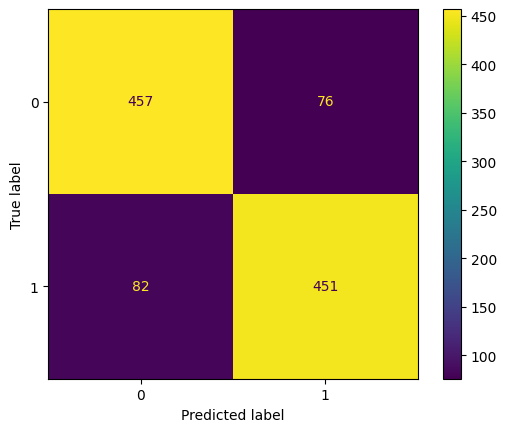

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(data["test"]["label"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Clear widget state
from IPython.display import display, Javascript
import json

# Clear widgets JavaScript
display(Javascript('''
    if (typeof IPython !== 'undefined') {
        IPython.notebook.metadata.widgets = {
            "application/vnd.jupyter.widget-state+json": {
                "state": {},
                "version_major": 2,
                "version_minor": 0
            }
        }
    }
'''))

print("Widget state cleared. Please save the notebook.")

<IPython.core.display.Javascript object>

Widget state cleared. Please save the notebook.
